# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

Lista de tareas:
- [x] Cargar los datos.
- [x] Preprocesar los datos, si es necesario.
- [x] Realizar un análisis exploratorio de datos y concluir sobre el desequilibrio de clases.
- [x] Realizar el preprocesamiento de datos para el modelado.
- [x] Entrenar al menos tres modelos diferentes para el conjunto de datos de entrenamiento.
- [x] Probar los modelos para el conjunto de datos de prueba.
- [x] Escribir algunas reseñas y clasificar con todos los modelos.
- [x] Buscar las diferencias entre los resultados de las pruebas de los modelos en los dos puntos anteriores. Intentar explicarlas.
- [x] Exponer hallazgos.

## Inicialización

In [1]:
!pip install nltk scikit-learn

In [2]:
import math

import numpy as np
import pandas as pd
import re # Importamos el módulo `re` para trabajar con expresiones regulares (para limpiar texto).
import nltk
import string
import spacy  # Importamos `spacy`, una biblioteca de Procesamiento de Lenguaje Natural (NLP).

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.dummy import DummyClassifier

from lightgbm import LGBMClassifier

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from tqdm.notebook import tqdm  # o simplemente tqdm si no estás en Jupyter
tqdm.pandas()  # Habilita tqdm en pandas

[nltk_data] Downloading package punkt to /home/student/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/student/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [4]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [5]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [6]:
#Analizamos las columnas disponibles en DF
df_reviews.head(5)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [8]:
#Verificar valores ausentes
print(df_reviews.isna().sum())
#Verificar valores duplicados
print(df_reviews.duplicated().sum())
print("Reseñas únicas:", df_reviews['review'].nunique())

# Mostrar reseñas duplicadas por texto (sin importar etiqueta o parte del dataset)
duplicated_reviews = df_reviews[df_reviews.duplicated(subset='review', keep=False)]

# Mostramos las reseñas duplicadas y sus etiquetas
print(duplicated_reviews.sort_values('review').head(10))  # solo mostramos las 10 primeras para no saturar


tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64
0
Reseñas únicas: 47240
          tconst title_type                        primary_title  \
33040  tt0145503      movie                             Sunshine   
33041  tt0145503      movie                             Sunshine   
36174  tt0082252      movie  The Decline of Western Civilization   
36175  tt0082252      movie  The Decline of Western Civilization   
36803  tt0436295      movie                 The Fall of Fujimori   
36804  tt0436295      movie                 The Fall of Fujimori   
16813  tt0119305      movie                            Homegrown   
16814  tt0119305      movie                            Homegro

- Hay cuatro valores ausentes, podemos eliminarlos sin problema.
- Hay 90 reseñas duplicadas, así que vamos a eliminarlas para evitar problemas con el entrenamiento y no tener información irrelevante.

In [9]:
df_reviews = df_reviews.dropna(axis='rows')
print(df_reviews.isna().sum())
df_reviews = df_reviews.drop_duplicates(subset=['review']).reset_index()
print(df_reviews.duplicated().sum())

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     0
votes              0
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64
0


## EDA

Veamos el número de películas y reseñas a lo largo de los años.

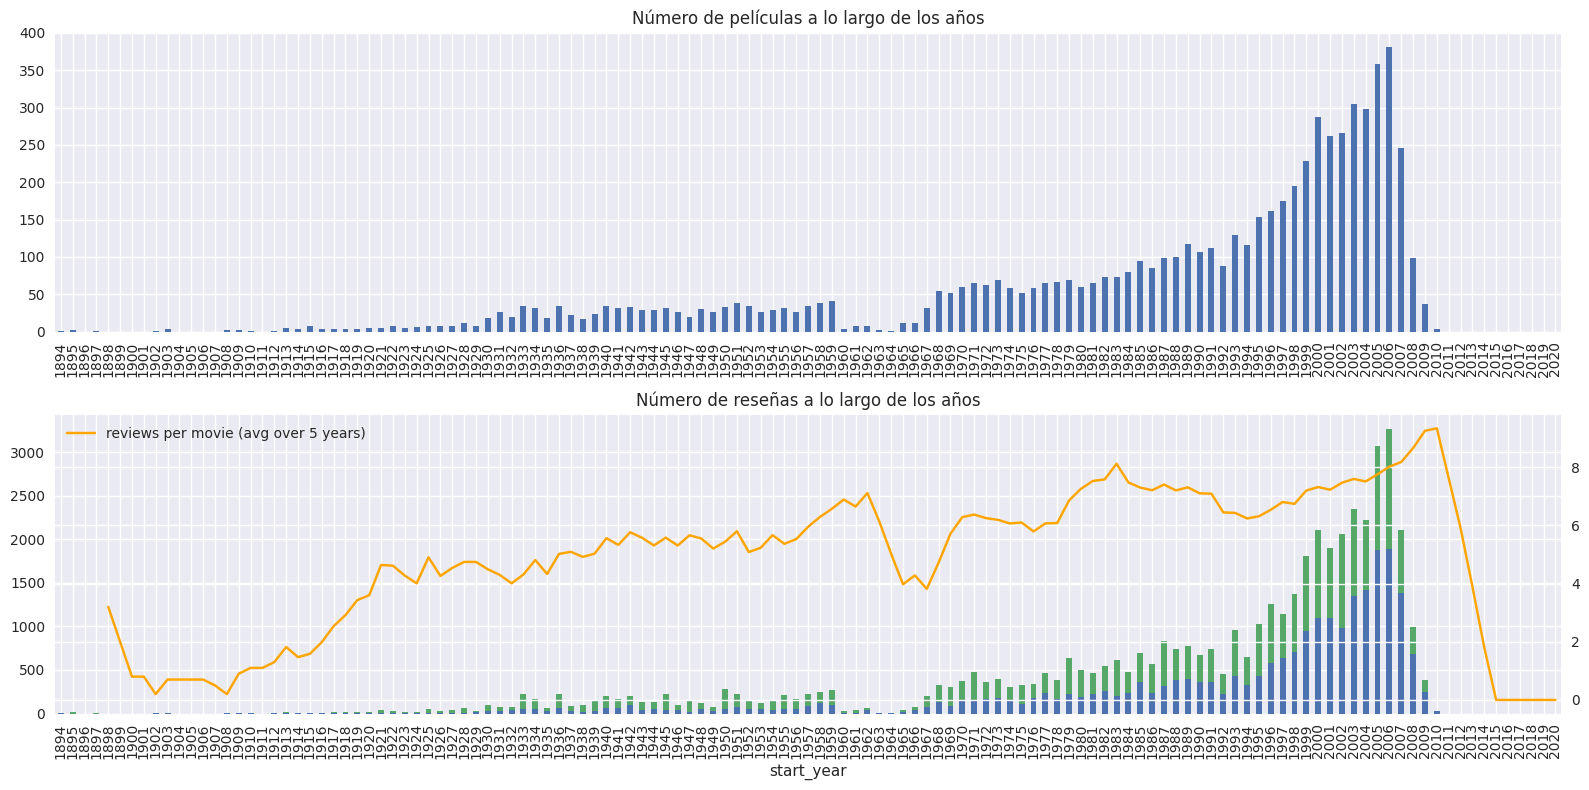

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

**Número de Películas por año:**
La primera gráfica de barras muestra la distribución anual de películas desde los inicios del cine (1894) hasta la actualidad. Se observa un crecimiento exponencial en la producción cinematográfica lo que sugiere la necesidad de estratificar los datos por períodos históricos para evitar sesgos temporales en el modelo.

**Número de Reseñas por Año:**
La segunda gráfica refleja la cantidad de reseñas registradas en el conjunto de datos IMDB, con un aumento progresivo que supera las 3,000 reseñas en años recientes. Este incremento está correlacionado con el crecimiento de películas, pero destaca que la densidad de reseñas por película varía significativamente entre décadas (ej. clásicos con muchas reseñas vs. películas modernas con menos).


### Análisis del número de reseñas por película'

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

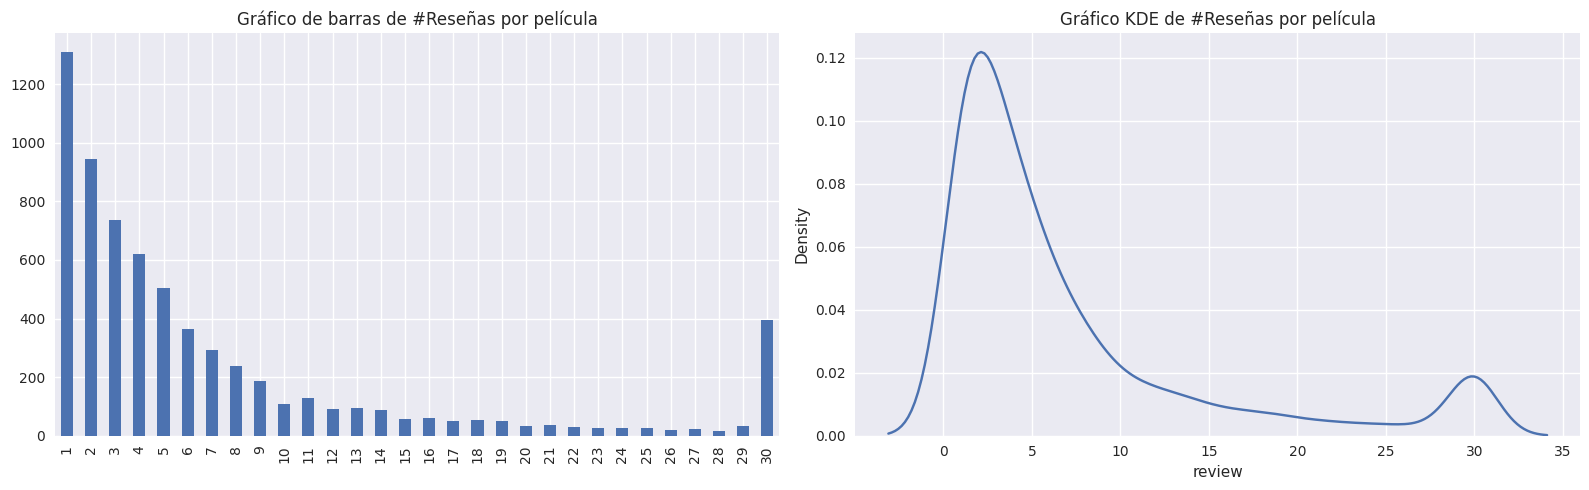

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

**Análisis de la Distribución de Reseñas por Película**
La gráfica muestra la distribución de películas según la **cantidad de reseñas** que tienen en el dataset limitado (`df_limitado`).

#### Ejes:

* **Eje X (horizontal):** Número de reseñas por película (por ejemplo: 1, 2, 3... hasta 30).
* **Eje Y (vertical):** Número de películas que tienen exactamente esa cantidad de reseñas.

#### Observaciones clave:

* La mayoría de las películas tienen **solo 1 reseña**, lo cual se representa por la barra más alta en la posición 1 del eje X.
* A medida que aumenta el número de reseñas (hacia la derecha), **la cantidad de películas disminuye** considerablemente, mostrando una **distribución de tipo cola larga**.
* **Ninguna película tiene más de 30 reseñas**, lo cual confirma visualmente que se aplicó un recorte o filtro en el dataset original (probablemente para limitar a 50 reseñas máximo por película).
* Hay un **ligero repunte** en el valor del eje X = 30, lo que indica que varias películas alcanzaron justo ese límite antes de ser truncadas.

#### Interpretación general:

* Esta distribución sugiere que la base de datos contiene muchas películas poco comentadas, y unas pocas con un número moderado de reseñas.


### Comprobación del balance entre reseñas positivas y negativas

In [12]:
df_reviews['pos'].value_counts()

0    23680
1    23558
Name: pos, dtype: int64

El conjunto de datos presenta un **equilibrio casi perfecto** entre reseñas positivas y negativas:

- Reseñas positivas (clase 1): 23,558
- Reseñas negativas (clase 0): 23,680
Análisis de Balanceo de Clases

**Distribución equilibrada:**

- La diferencia entre ambas clases es mínima (122 reseñas, ~0.26%), lo que indica que no se requieren técnicas de balanceo agresivas (como oversampling/undersampling).
- El modelo podrá entrenarse sin sesgo inicial hacia una clase específica.

**⚠️ Consideraciones para el entrenamiento:**
- Estratificación en train/test:
    - Asegurar que la proporción 50/50 se mantenga en los splits:

In [13]:
"""from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42"""

'from sklearn.model_selection import train_test_split\nX_train, X_test, y_train, y_test = train_test_split(\n    X, y, test_size=0.2, stratify=y, random_state=42'

### Análisis de distribución de puntuaciones

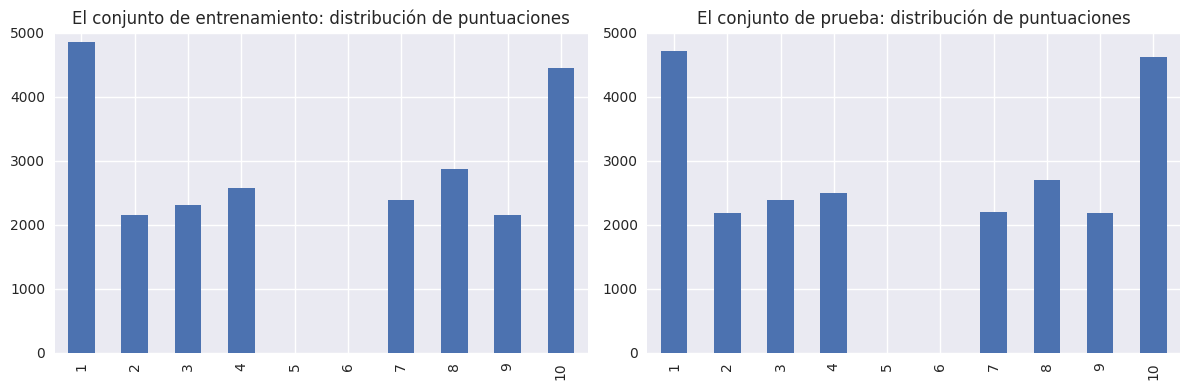

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Las gráficas anteriores muestran la distribución de puntuaciones en una escala del 1 al 10 asignadas a las películas en el conjunto de datos. Los hallazgos principales son los siguientes:

**Existen extremos dominantes:**
- Las calificaciones más frecuentes son 1 (casi 5000 películas) y 10 (cerca de 4500 películas), lo que sugiere una tendencia de los usuarios a calificar películas como perfectas o pésimas, con pocos matices intermedios.
- Valores ausentes: No hay calificaciones de 5 o 6, indicando una brecha en puntuaciones neutras.

**Existe una distribución desigual:**

Los datos en el rango bajo de calificaciones de 1 a 4 son los siguientes:
- 1: ~5000 películas (máximo absoluto).
- 2: ~2000 películas.
- 3: <2500 películas.
- 4: ~2500 películas.
En el tango alto (7-10):
- 7: <2500 películas.
- 8: ~3000 películas (segundo pico más alto).
- 9: ~2000 películas.
- 10: ~4500 películas (pico máximo).

En la gráfica es más fácil observar la distribución de los datos. Como el objetivo del modelo es predecir reseñas negativas, no es necesario hacer caso a la ausencia de reseñas neutrales (5-6) y de hecho podemos observar un buen equilibrio entre reseñas negativas (1-4) y reseñas positivas (7-10). El único cambio que beneficiaría al modelo sería agrupar las calificaciones de acuerdo a su rango y clasificarlas como positiva y negativa, por suerte la columna 'pos' revela exactamente eso e indica 1 si es una reseña positiva y 0 si es negativa. por lo que no hay que hacer ningún cambio.

### Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


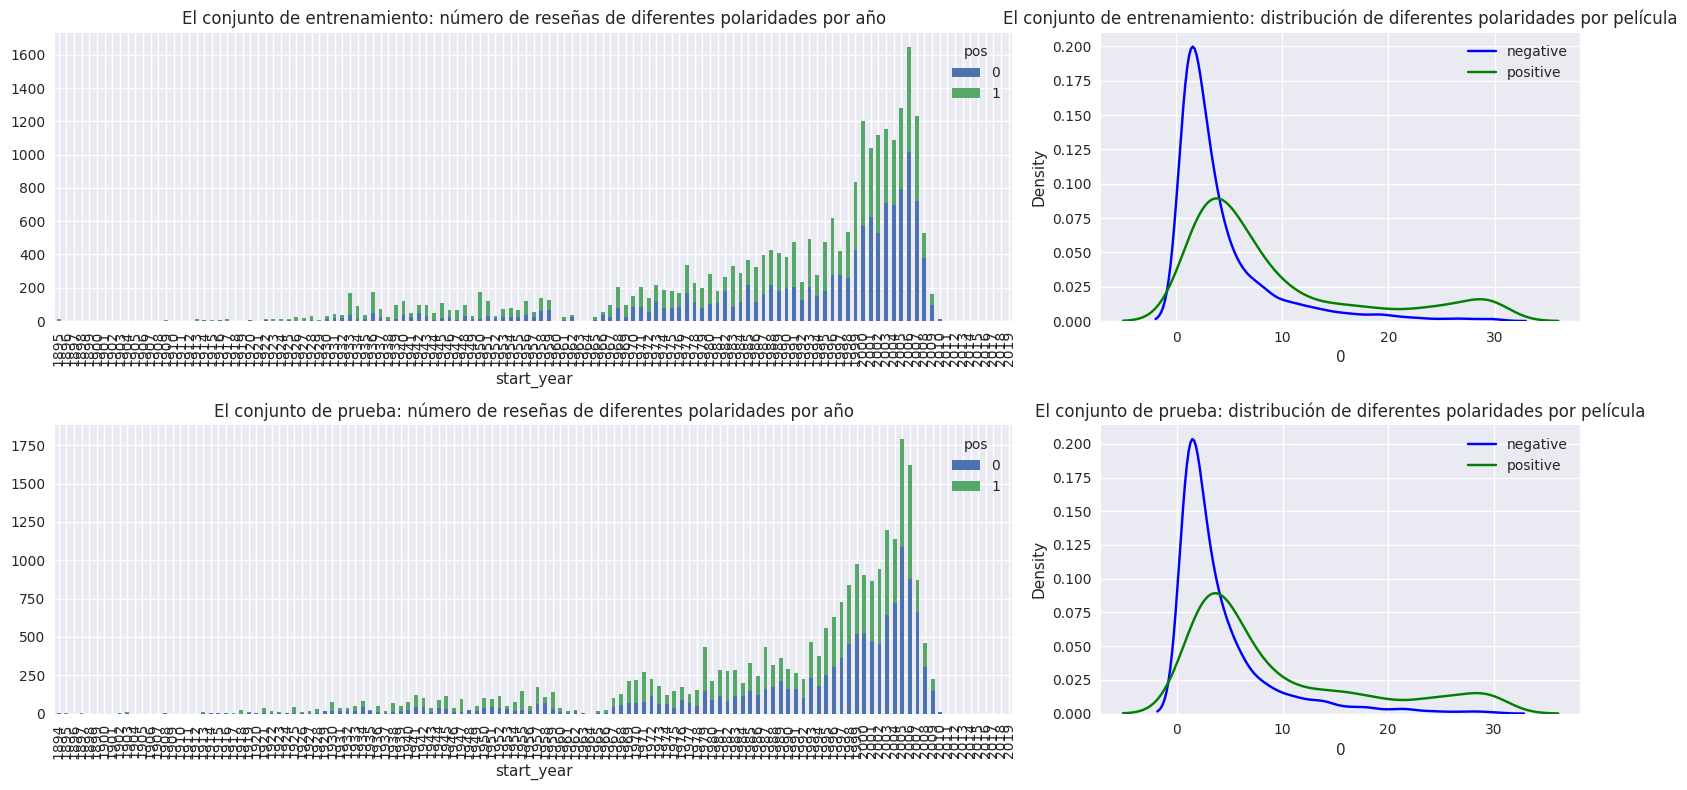

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

In [16]:
df_reviews['pos'].value_counts()

0    23680
1    23558
Name: pos, dtype: int64

En las gráficas anteriores podemos observar la distribución en cuanto a reseñas positivas y negativas. A primer vista, las reseñas positivas tienen una mayor densidad y cantidad. Sin embargo, cuando contamos el número de reseñas positivas y negativas en el dataset observar una severa similitud en la cantidad de ambas, lo que nos habla de una muy buena distribución para entrenar al modelo. En cuanto a la distribución de datos en el conjunto de entrenamiento y prueba, también se demuestra que es adecuada y similar.

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [17]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Reducción del dataset

Debido a la gran cantidad de datos y la baja potencia de mi computadora, he tomado la decisión de reducir levemente el dataset, dejando sólo las películas que tengan más de 5 reseñas, lo cual también contribuye a la disminución del ruido que generaba el desbalance entre películas con pocas reseñas.

Películas únicas: 3033
Total de reseñas: 39338

Distribución de clases:
1    21840
0    17498
Name: pos, dtype: int64


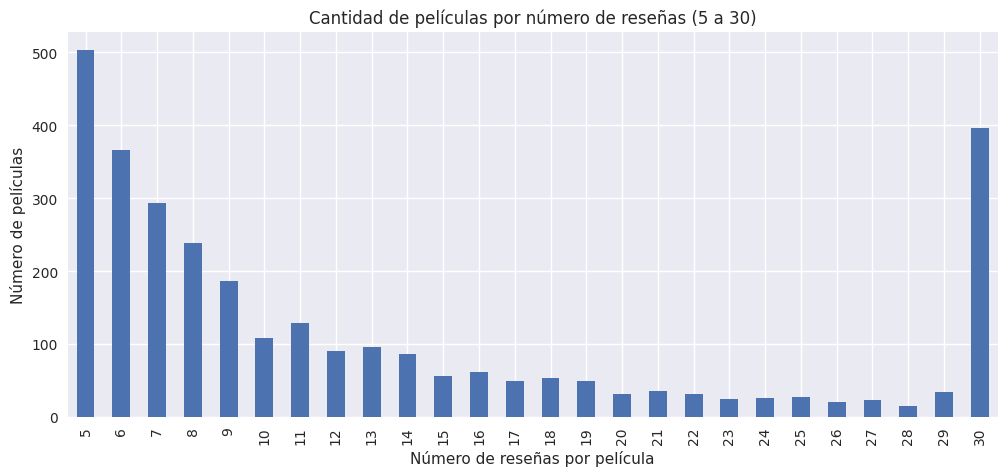

In [18]:
# Paso 1: Filtrar películas con al menos 5 reseñas
# Agrupamos por 'tconst' y contamos cuántas reseñas tiene cada película
conteo_reseñas = df_reviews.groupby('tconst')['review'].count()

# Creamos una lista de tconst (películas) que tienen 5 o más reseñas
peliculas_validas = conteo_reseñas[conteo_reseñas >= 5].index

# Filtramos el dataframe original conservando solo esas películas
df_filtrado = df_reviews[df_reviews['tconst'].isin(peliculas_validas)].copy()

# Paso 2: Reducir a máximo 30 reseñas por película (selección aleatoria)
# Usamos groupby y sample para limitar a 30 reseñas como máximo por película
df_reducido = (
    df_filtrado
    .groupby('tconst', group_keys=False)  # evita niveles extra al agrupar
    .apply(lambda x: x.sample(n=min(30, len(x)), random_state=42))  # toma hasta 30 reseñas por película
)

# Paso 3: Verificar la distribución resultante

# Número total de películas después del filtrado
print("Películas únicas:", df_reducido['tconst'].nunique())

# Número total de reseñas después del filtrado
print("Total de reseñas:", len(df_reducido))

# Recuento de clases (0 = negativas, 1 = positivas)
print("\nDistribución de clases:")
print(df_reducido['pos'].value_counts())

dft = df_reducido.groupby('tconst')['review'].count().value_counts().sort_index()

plt.figure(figsize=(12, 5))
dft.plot.bar()
plt.title('Cantidad de películas por número de reseñas (5 a 30)')
plt.xlabel('Número de reseñas por película')
plt.ylabel('Número de películas')
plt.show()


In [19]:
# Hacemos la comparativa entre el dataset reducido y el original
df_reviews.info()
df_reducido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47238 entries, 0 to 47237
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            47238 non-null  int64  
 1   tconst           47238 non-null  object 
 2   title_type       47238 non-null  object 
 3   primary_title    47238 non-null  object 
 4   original_title   47238 non-null  object 
 5   start_year       47238 non-null  int64  
 6   end_year         47238 non-null  object 
 7   runtime_minutes  47238 non-null  object 
 8   is_adult         47238 non-null  int64  
 9   genres           47238 non-null  object 
 10  average_rating   47238 non-null  float64
 11  votes            47238 non-null  Int64  
 12  review           47238 non-null  object 
 13  rating           47238 non-null  int64  
 14  sp               47238 non-null  object 
 15  pos              47238 non-null  int64  
 16  ds_part          47238 non-null  object 
 17  idx         

Gracias a la reducción, eliminamos 7900 datos y conservamos un balance de clases razonable (Distribución de clases: 1 -> 21840 | 0 -> 17498).

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [20]:
#print(df_reviews)
print(df_reducido['review'].iloc[0])

The first film ever made. Workers streaming from a factory, some cycling, most walking, moving right or left. Along with Melies, the Lumieres are both the starting point and the point of departure for cinema - with Melies begins narrative fiction, cinema, fantasy, artifice, spectacle; with the Lumieres pure, unadorned, observation. The truth. There are many intellectuals who regret the ossification of cinema from the latter into the tired formulae of the former. But consider this short again. There is nothing 'objective' about it. The film is full of action - a static, inhuman scene burst into life, activity, and the quiet harmony of the frame is ruptured, decentred from the back to right or left (but never, of course, the front, where the camera is). And yet the camera stands stock still, contains the energy, the possible subversion, subordinates it to its will. The cinematograph may be a revolutionary invention, but it will be used for conservative purposes - to map out the world, ed

### Normalización + spaCy

In [21]:
# Cargamos el modelo pequeño de inglés de spaCy, pero desactivamos el análisis sintáctico ('parser') y el reconocimiento de entidades ('ner'), porque no los necesitamos y eso acelera el procesamiento.
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
corpus = df_reducido['review']  # Extraemos solo la columna de reseñas como una lista/serie de texto.

"""Creamos una función que elimine los símbolos y se conserven solo letras y apóstrofos"""
def norm_text(text):
    # Usamos una expresión regular para conservar solo letras (mayúsculas o minúsculas) y apóstrofos.
    # Todo lo que no coincida será reemplazado por un espacio.
    clean_text = re.sub(r'[^A-Za-z\']', ' ', text)

    # Eliminamos espacios duplicados dejando solo uno entre palabras:
    clean_text = " ".join(clean_text.split())

    return clean_text # Devuelve el texto limpio

"""Creamos una función que convierta las palabras del texto a su forma base (lematización)"""
def lemmatize(text):
    doc = nlp(text.lower()) # Convertimos el texto a minúsculas y lo pasamos por el modelo NLP.
    lemmas = [] # Lista vacía donde vamos a guardar las palabras lematizadas.
    
    # Recorremos cada palabra procesada (token) y extraemos su forma base (lemma).
    for token in doc:
        # Agregamos condición para eliminar stopwords y signos de puntuación
        if not token.is_stop and not token.is_punct:
            lemmas.append(token.lemma_)
    # Devolvemos los lemas en un solo texto separado por espacios.
    return ' '.join(lemmas)

# Seleccionamos una reseña específica
# Obtenemos el texto de la reseña correspondiente al índice seleccionado.
review = df_reducido['review'].iloc[0]

"""# Imprimimos el texto original de la reseña.
print('El texto original:', review)
print()

# Imprimimos el texto después de limpiarlo y lematizarlo.
# Esto nos da una versión más simple y lista para análisis de NLP.
print('El texto lematizado:', lemmatize(norm_text(review)))"""

# Aplicamos lo anterior a toda la columna 'review', creando una nueva columna
# Versión OPTIMIZADA (usando .apply() para evitar bucles)
df_reducido['review_norm_spacy'] = df_reducido['review'].progress_apply(lambda x: lemmatize(norm_text(x)))

# Mostrar ejemplo antes/después
print("Original:\n", df_reducido['review'].iloc[1])
print("\nNormalizado:\n", df_reducido['review_norm_spacy'].iloc[1])

"""
texts = df_reviews['review'].apply(norm_text).tolist()
lemmatized = [' '.join([t.lemma_ for t in doc]) for doc in nlp.pipe(texts, batch_size=50)]
df_reviews['review_norm'] = lemmatized"""

  0%|          | 0/39338 [00:00<?, ?it/s]

Original:
 Of course, he did have to INVENT EVERYTHING about cinematography, film directing, etc. before he could make classics like "The Gardner," so I suppose he may be forgiven this initial excursion into mere sociological documentary. Today we call them "home movies," and they are just as boring now as this one is

Normalizado:
 course invent cinematography film direct etc classic like gardner suppose forgive initial excursion mere sociological documentary today home movie boring


"\ntexts = df_reviews['review'].apply(norm_text).tolist()\nlemmatized = [' '.join([t.lemma_ for t in doc]) for doc in nlp.pipe(texts, batch_size=50)]\ndf_reviews['review_norm'] = lemmatized"

**La función norm_text normaliza el texto y la función lemmatize utiliza spaCy.**

In [22]:
print(df_reducido['review_norm_spacy'])
print(df_reducido['review'])

20228    film worker stream factory cycling walk move r...
20223    course invent cinematography film direct etc c...
20232    imdb give hefty vote favourite film enjoy seco...
20233    film need view sense time place lumiere family...
20225    story say december small group thirty people g...
                               ...                        
4980     simply watch movie sarah give star movie easil...
4975     movie crap not differently beginning know go c...
4978     earth like watch episode neighbour drink bottl...
4982     give movie think general dislike movie people ...
4974     movie probably bad movie history rent chance r...
Name: review_norm_spacy, Length: 39338, dtype: object
20228    The first film ever made. Workers streaming fr...
20223    Of course, he did have to INVENT EVERYTHING ab...
20232    You're using the IMDb. You've given some hefty...
20233    All films made before 1912 really need to be v...
20225    Story says that on that on December 28, 1895, ...
  

### Normalización + NLTK

In [23]:
# Inicializar lematizador y stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def norm_text_nltk(text):
    """Normaliza el texto: elimina caracteres no alfabéticos y convierte a minúsculas"""
    clean_text = re.sub(r'[^A-Za-z\']', ' ', text)  # Conserva letras y apóstrofes
    clean_text = " ".join(clean_text.split())        # Elimina espacios múltiples
    return clean_text.lower()                        # Convertir a minúsculas

def lemmatize_nltk(text):
    """Lematiza el texto usando NLTK"""
    tokens = word_tokenize(text)                     # Tokenización
    lemmas = [
        lemmatizer.lemmatize(token) 
        for token in tokens 
        if token not in stop_words                  # Opcional: eliminar stopwords
    ]
    return ' '.join(lemmas)

# Versión modificada para debug
def preprocess_with_nltk(df, text_column='review', new_column='review_norm_nltk'):
    """
    Procesa un DataFrame aplicando normalización y lematización con NLTK.
    
    Args:
        df (pd.DataFrame): DataFrame con los datos.
        text_column (str): Nombre de la columna de texto a procesar.
        new_column (str): Nombre de la nueva columna para el texto procesado.
    
    Returns:
        pd.DataFrame: DataFrame con la nueva columna añadida.
    """
    try:
        # Verificar si existe la columna de entrada
        if text_column not in df.columns:
            raise ValueError(f"La columna {text_column} no existe en el DataFrame")
        
        # Debug: muestra progreso
        print(f"Procesando {len(df)} registros...")
        
        # Aplicar procesamiento con manejo de errores
        df[new_column] = df[text_column].progress_apply(
            lambda x: lemmatize_nltk(norm_text_nltk(x)) if pd.notnull(x) else ""
        )
        
        print("Procesamiento completado exitosamente")
        return df
    
    except Exception as e:
        print("Error durante el procesamiento:", e)
        return None  # o df sin modificar



In [55]:
# Aplicamos la normalización y el procesamiento con NLTK 
df_reducido = preprocess_with_nltk(df_reducido, text_column='review', new_column='review_norm_nltk')

Procesando 39338 registros...


  0%|          | 0/39338 [00:00<?, ?it/s]

Procesamiento completado exitosamente


Procesar los datos con NLTK es mucho más rápido que con spaCy.

In [56]:
# Después de ejecutar preprocess_with_nltk()
if 'review_norm_nltk' in df_reviews.columns:
    print("Columna creada exitosamente")
    print("Ejemplo de resultado:")
    print(df_reviews[['review', 'review_norm_nltk']].head())
else:
    print("La columna no fue creada. Revisa los mensajes de error anteriores")

La columna no fue creada. Revisa los mensajes de error anteriores


In [57]:
print(df_reducido['review_norm_nltk'])

20228    first film ever made worker streaming factory ...
20223    course invent everything cinematography film d...
20232    're using imdb 've given hefty vote favourite ...
20233    film made really need viewed sense time place ...
20225    story say december small group thirty three pe...
                               ...                        
4980     simply watched movie sarah also giving star si...
4975     movie crap cant put differently since beginnin...
4978     earth like watching episode neighbour drinking...
4982     gave movie think general dislike movie due peo...
4974     movie probably one worst movie made history re...
Name: review_norm_nltk, Length: 39338, dtype: object


In [58]:
df_reducido.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39338 entries, 20228 to 4974
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              39338 non-null  int64  
 1   tconst             39338 non-null  object 
 2   title_type         39338 non-null  object 
 3   primary_title      39338 non-null  object 
 4   original_title     39338 non-null  object 
 5   start_year         39338 non-null  int64  
 6   end_year           39338 non-null  object 
 7   runtime_minutes    39338 non-null  object 
 8   is_adult           39338 non-null  int64  
 9   genres             39338 non-null  object 
 10  average_rating     39338 non-null  float64
 11  votes              39338 non-null  Int64  
 12  review             39338 non-null  object 
 13  rating             39338 non-null  int64  
 14  sp                 39338 non-null  object 
 15  pos                39338 non-null  int64  
 16  ds_part            

Ahora ya tenemos tres columnas con las reseñas: review que tiene las reseñas crudas y sin procesar, review_norm_spacy que tiene las reseñas procesadas con spaCy y review_norm_nltk que tiene las reseñas procesadas con NLTK. Esto nos ayudará más adelante a comparar los modelos y encontrar el mejor F1 score.

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [59]:
# 1. Filtrar los datos en train y test desde df_reducido (dataset ya reducido)
df_train = df_reducido.query('ds_part == "train"').copy()
df_test = df_reducido.query('ds_part == "test"').copy()

#DATOS CON SPACY + normalización
# 2. Extraer características (X) y etiquetas (y) de cada subconjunto 
X_train_spacy = df_train['review_norm_spacy']  # Texto procesado
y_train_spacy = df_train['pos']          # Etiqueta binaria

X_test_spacy = df_test['review_norm_spacy']
y_test_spacy = df_test['pos']

# DATOS CON NLTK + normalización
X_train_nltk = df_train['review_norm_nltk']  
y_train_nltk = df_train['pos']         

X_test_nltk = df_test['review_norm_nltk']
y_test_nltk = df_test['pos']

# DATOS SIN PROCESAR
X_train = df_train['review']  
y_train = df_train['pos']         

X_test = df_test['review'] 
y_test = df_test['pos']

print(X_train_spacy.shape)
print(X_test_spacy.shape)

print(X_train_nltk.shape)
print(X_test_nltk.shape)

(19878,)
(19460,)
(19878,)
(19460,)


## Trabajar con modelos

### Modelo 0 - Constante

El modelo DummyClassifier es útil como línea base (baseline): nos permite comparar el rendimiento de nuestros modelos reales contra una estrategia “tonta” (como predecir siempre la clase más frecuente).

#### Vectorización con TF-IDF a datos SIN PROCESAR

In [60]:
# 1. Cargar stopwords en inglés
stop_words = set(stopwords.words('english'))

# 2. Crear el vectorizador TF-IDF con palabras vacías y limitar a 5000 características
tfidf = TfidfVectorizer(stop_words=stop_words, max_features=5000)

# 3. Ajustar y transformar solo sobre los datos de entrenamiento
X_train_tfidf = tfidf.fit_transform(X_train)

# 4. Transformar los datos de prueba con el mismo vectorizador (sin ajustar de nuevo)
X_test_tfidf = tfidf.transform(X_test)

=== Reporte del Modelo Dummy ===
          train  test
Accuracy   0.56  0.56
F1         0.71  0.71
APS        0.56  0.56
ROC AUC    0.50  0.50


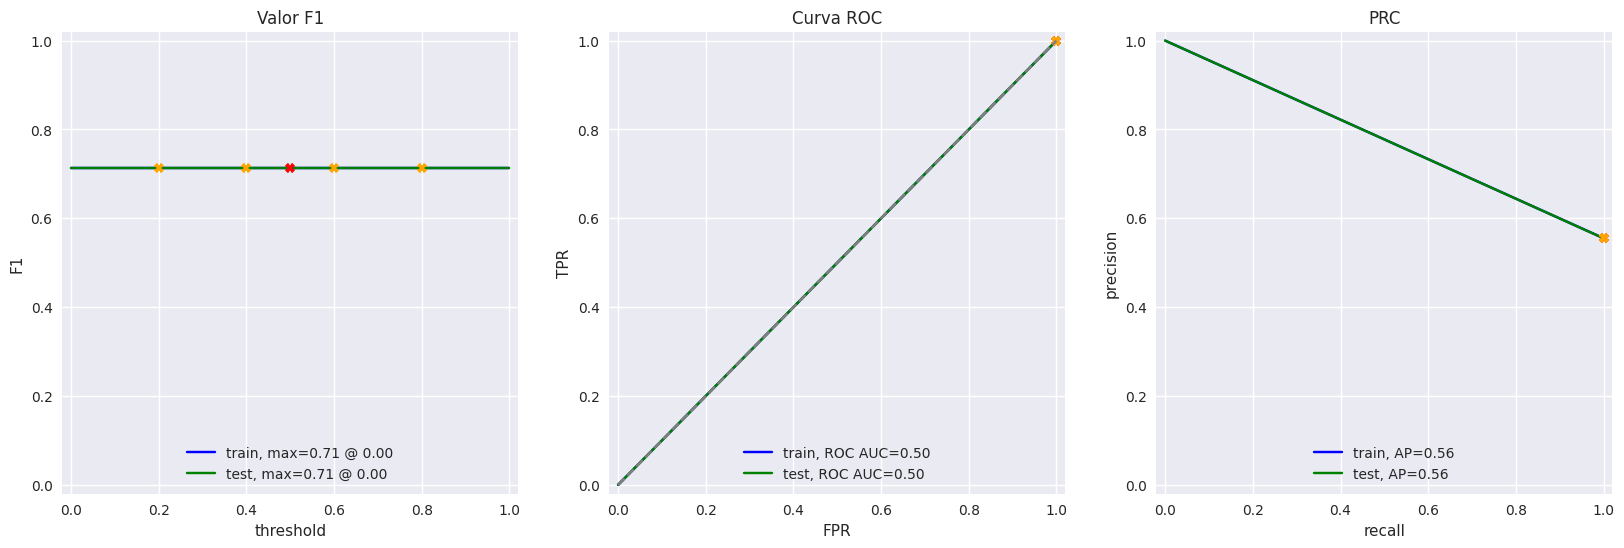

In [61]:
# Crear el modelo Dummy
# strategy="most_frequent" predice siempre la clase más común (en este caso probablemente 1 o 0)
modelo_dummy = DummyClassifier(strategy="most_frequent")

# Entrenar el modelo
modelo_dummy.fit(X_train_tfidf, y_train)

# Hacer predicciones
y_dummy_pred = modelo_dummy.predict(X_test_tfidf)

# Evaluar rendimiento
print("=== Reporte del Modelo Dummy ===")
evaluate_model(modelo_dummy, X_train_tfidf, y_train, X_test_tfidf, y_test)


El modelo Dummy no es útil para detectar reseñas negativas.
El F1 score de 0.71 para clase 1 (positiva) es la línea base: los modelos reales deben superar ese valor de F1 para justificar su uso.

### Modelo 1 - NLTK, TF-IDF y LR

#### Vectorización con TF-IDF a datos procesados con NLTK

Los datos con el sufijo **_nltk** ya están normalizados y procesados con NLTK.

In [62]:
# 1. Cargar stopwords en inglés
stop_words_nltk = set(stopwords.words('english'))

# 2. Crear el vectorizador TF-IDF con palabras vacías y limitar a 5000 características
tfidf_nltk = TfidfVectorizer(stop_words=stop_words_nltk, max_features=5000)

# 3. Ajustar y transformar solo sobre los datos de entrenamiento
X_train_tfidf_nltk = tfidf_nltk.fit_transform(X_train_nltk)

# 4. Transformar los datos de prueba con el mismo vectorizador (sin ajustar de nuevo)
X_test_tfidf_nltk = tfidf_nltk.transform(X_test_nltk)

In [63]:
# Creamos el modelo de regresión logística
modelo_lr_nltk = LogisticRegression(max_iter=1000, random_state=42)

# Entrenamos el modelo con los vectores TF-IDF
modelo_lr_nltk.fit(X_train_tfidf_nltk, y_train_nltk)

# Usamos el modelo para predecir las etiquetas en el conjunto de prueba
y_pred_nltk = modelo_lr_nltk.predict(X_test_tfidf_nltk)

          train  test
Accuracy   0.92  0.89
F1         0.93  0.90
APS        0.98  0.96
ROC AUC    0.98  0.96


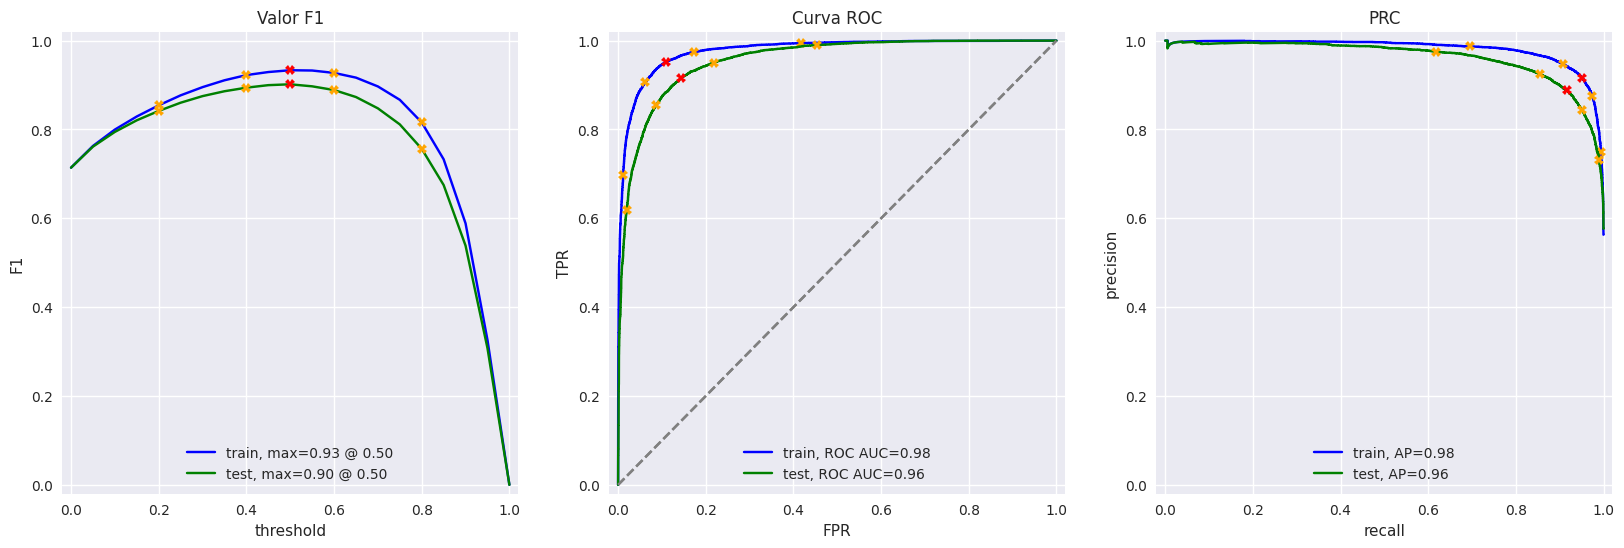

In [64]:
# Evaluación del modelo con datos procesados con NLTK
evaluate_model(modelo_lr_nltk, X_train_tfidf_nltk, y_train_nltk, X_test_tfidf_nltk, y_test_nltk)

**Accuracy (Exactitud) (.89 en test):**
- El 92 % de las reseñas en entrenamiento y el 89 % en prueba fueron clasificadas correctamente. Esto indica que el modelo generaliza bastante bien y no hay un sobreajuste grave.

**F1 Score (.90 en test):** 
- Muestra el puntaje de equilibrio entre precisión y recall, en este caso, un 0.90 en prueba indica que el modelo logra un buen balance detectando reseñas negativas correctamente sin muchos falsos positivos o falsos negativos, además de superar con creces el puntaje del modelo Dummy.

**APS (Average Precision Score) (.96 en test):** 
- Esta métrica evalúa la precisión en todos los niveles de recall. 0.96 es excelente, sugiere que las predicciones de probabilidad están bien calibradas.

**ROC AUC (.96 en test):** 
- Un 0.96 en test indica que el modelo tiene un poder de discriminación muy alto para separar reseñas negativas de positivas.

En resumen, el modelo basado en **NLTK + TF-IDF + Regresión Logística** tiene un rendimiento muy sólido, con métricas equilibradas y consistentes entre entrenamiento y prueba.
Puede considerarse un buen modelo base o incluso final, si otros modelos no lo superan con claridad.

### Modelo 2 - spaCy, TF-IDF y LR

Este modelo también utiliza TF-IDF, pero la limpieza del texto será más sofisticada usando spaCy, una librería avanzada de procesamiento de lenguaje natural. Esto puede mejorar la calidad de los datos de entrada al modelo.
La columna **['review_norm_spacy']** ya tiene las reseñas normalizadas y procesadas con spaCy, los datos con el sufijo **_spacy** ya fueron normalizados y procesados con esta librería.

#### Vectorización a datos procesados con spaCy

In [65]:
# 1. Crear el vectorizador TF-IDF con palabras vacías y limitar a 5000 características
tfidf_spacy = TfidfVectorizer(max_features=5000)

# 2. Ajustar y transformar solo sobre los datos de entrenamiento
X_train_tfidf_spacy = tfidf_spacy.fit_transform(X_train_spacy)

# 3. Transformar los datos de prueba con el mismo vectorizador (sin ajustar de nuevo)
X_test_tfidf_spacy = tfidf_spacy.transform(X_test_spacy)

In [66]:
# Creamos el modelo de regresión logística
modelo_lr_spacy = LogisticRegression(max_iter=1000, random_state=42)

# Entrenamos el modelo con los vectores TF-IDF
modelo_lr_spacy.fit(X_train_tfidf_spacy, y_train_spacy)

# Usamos el modelo para predecir las etiquetas en el conjunto de prueba
y_pred_spacy = modelo_lr_spacy.predict(X_test_tfidf_spacy)

          train  test
Accuracy   0.92  0.88
F1         0.93  0.89
APS        0.98  0.96
ROC AUC    0.97  0.95


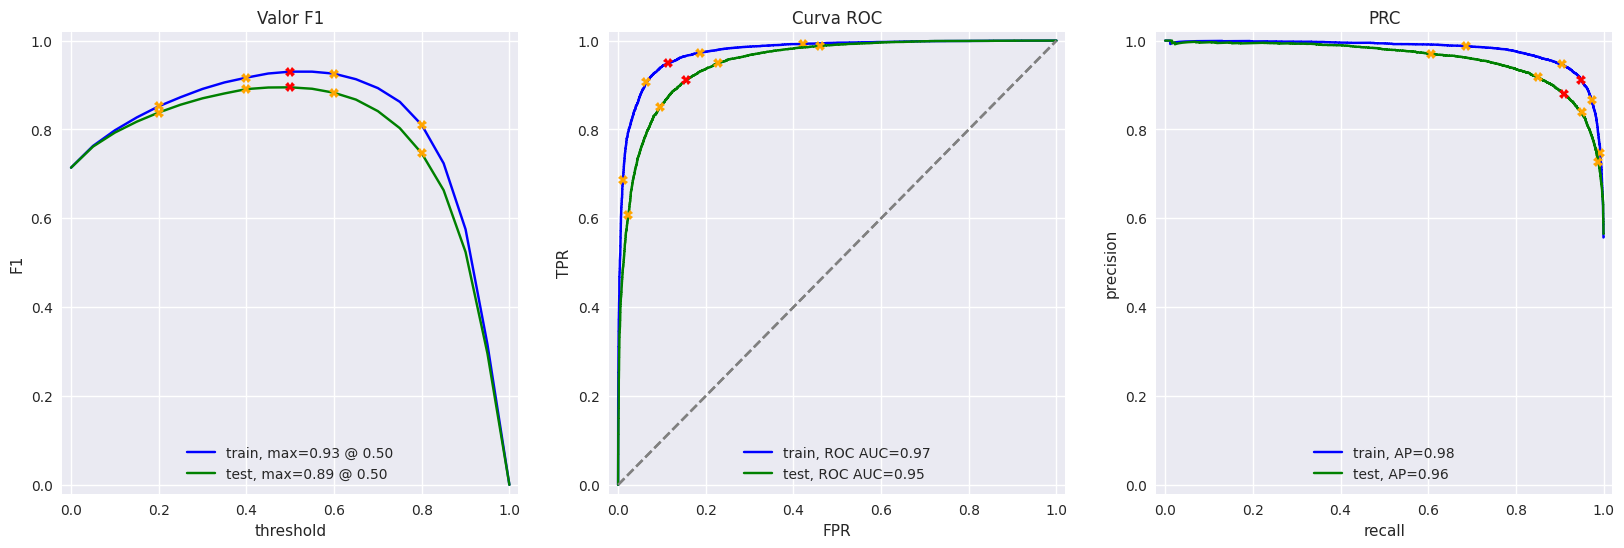

In [67]:
# Evaluación del modelo
evaluate_model(modelo_lr_spacy, X_train_tfidf_spacy, y_train_spacy, X_test_tfidf_spacy, y_test_spacy)

Los resultados muestran una gran similitud de puntajes comparados con los datos procesados con NLTK, la mayor diferencia se encuentra en el puntaje F1 score, el cual obtuvo en este caso .89 mientras que el modelo con NLTK obtuvo .90. Además, en la curva ROC AC, en el modelo con spacy muestra un .95 en test y un .97 en train, mientras que en los datos con NLTK muestra un .96 en test y un .98 en train.

**Accuracy (.89 en test)**
- La exactitud (o accuracy) es la proporción de predicciones correctas entre el total de predicciones.
- El modelo acertó el 89 % de las reseñas en el conjunto de entrenamiento. Es decir, de cada 100 reseñas, 89 fueron clasificadas correctamente como positivas o negativas.
  
**F1 Score (0.89 en test)**
- El F1 es el promedio armónico entre precisión y recall. En problemas de clasificación binaria (positivas vs negativas), este valor indica que el modelo detecta muy bien las reseñas negativas, sin equivocarse demasiado ni dejando pasar muchas.

**APS (Average Precision Score) (0.96 en test)**
- Mide qué tan buena es la curva de precisión-recall a distintos umbrales.
- Altos valores indican que incluso si el umbral de decisión cambia, el modelo sigue teniendo buena precisión y recall.
- Es una métrica muy robusta para desequilibrio de clases.

**ROC AUC (0.95 en test)**
- Muestra qué tan bien el modelo distingue entre reseñas positivas y negativas en general.
- Un valor de 0.95 significa que hay un 95% de probabilidad de que el modelo clasifique correctamente una reseña aleatoria negativa por encima de una positiva.

En conclusión el modelo de Regresión Lineal con datos procesados con spaCy es un modelo robusto. Sin embargo, comparado con el anterior con datos procesados con NLTK, este tiene 1% menos de probabilidad de acertar correctamente.

### Modelo 3 - spaCy, TF-IDF y LGBMClassifier

In [68]:
# 1. Crear vectorizador TF-IDF limitando a 5000 características
tfidf_spacy_lgbm = TfidfVectorizer(max_features=5000)

# 3. Ajustar el vectorizador solo con los datos de entrenamiento (nunca con test)
X_train_tfidf_spacy_lgbm = tfidf_spacy_lgbm.fit_transform(X_train_spacy)

# 4. Transformar los datos de prueba con el vectorizador ya entrenado
X_test_tfidf_spacy_lgbm = tfidf_spacy_lgbm.transform(X_test_spacy)

In [69]:
# 1. Crear el modelo LGBMClassifier (configuración básica)
modelo_lgbm_spacy = LGBMClassifier(random_state=42)

# 2. Entrenar el modelo con los datos vectorizados
modelo_lgbm_spacy.fit(X_train_tfidf_spacy_lgbm, y_train_spacy)


LGBMClassifier(random_state=42)

          train  test
Accuracy   0.92  0.86
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.94


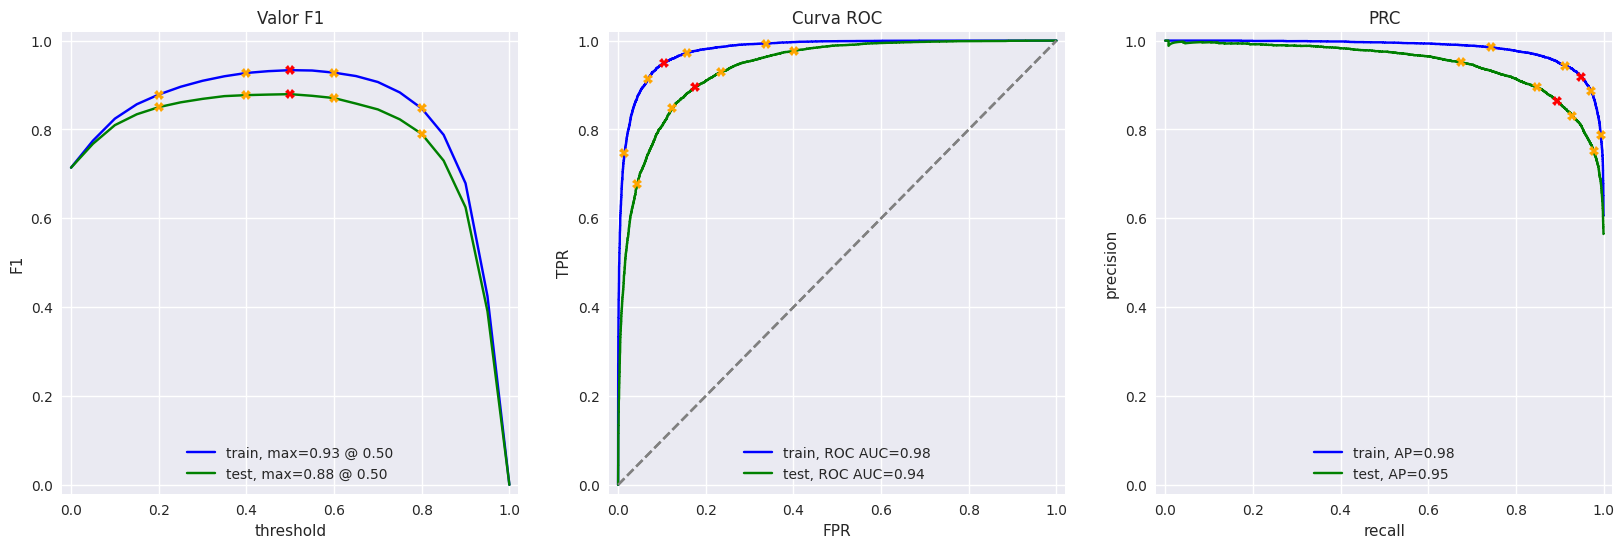

In [70]:
# Evaluar el rendimiento del modelo LGBM 
evaluate_model(
    modelo_lgbm_spacy,
    X_train_tfidf_spacy_lgbm, y_train_spacy,
    X_test_tfidf_spacy_lgbm, y_test_spacy
)

**Accuracy (Exactitud) (.86 en test):**
- Un puntaje en train de 0.92 significa que el 92% de las reseñas fueron clasificadas correctamente.
- Test: 0.86 → El rendimiento bajó ligeramente en datos no vistos, pero sigue siendo aceptable.
- 📉 Hay una pequeña caída (6%), lo cual puede sugerir un leve sobreajuste del modelo.

**F1 Score (.88 en test):**
- Train: 0.93, Test: 0.88
- Buena combinación entre precisión y recall.
- El valor sigue siendo alto, lo cual indica que el modelo detecta bien las críticas negativas sin muchos falsos positivos o negativos, pero no es mejor que los modelos de regresión lineal.

**Average Precision Score (APS) (.95 en test):**
- Train: 0.98, Test: 0.95
- Evalúa la calidad del modelo al clasificar probabilidades, muy útil en datos desbalanceados.
- Aquí también hay una ligera caída, pero sigue en un nivel excelente.

**ROC AUC:**
- Train: 0.98, Test: 0.94
- Mide qué tan bien el modelo separa reseñas positivas vs negativas.
- El valor es alto, pero muestra una pequeña diferencia entre entrenamiento y prueba que podría indicar sobre entrenamiento.

LGBM tiene una leve caída en datos de prueba, lo que sugiere que aunque aprende muy bien en entrenamiento, no generaliza tanto como la regresión logística en este caso, este puntaje quizás podría mejorar si hacemos un ajuste de hiperparámetros.

###  Modelo 9 - BERT

#### Reducción extra del dataset

In [71]:
# Seleccionar una muestra aleatoria
df_train_small = df_train.sample(n=200, random_state=42)
df_test_small = df_test.sample(n=50, random_state=42)

features_train_small = df_train_small['review_norm_nltk']
features_test_small = df_test_small['review_norm_nltk']

target_train_small = df_train_small['pos']
target_test_small = df_test_small['pos']

print(features_train_small.shape)
print(target_train_small.shape)
print(features_test_small.shape)
print(target_test_small.shape)

(200,)
(200,)
(50,)
(50,)


In [72]:
import torch
import transformers
from tqdm import tqdm
import numpy as np
import math

In [73]:
# Cargar el tokenizer y modelo preentrenado
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [74]:
# Reducimos la longitud máxima del texto (max_length) a 128 0 256 en vez de 512
# Bajar el tamaño de batch_size a 16 o 32 para no saturar la RAM.
def BERT_text_to_embeddings(texts, max_length=128, batch_size=16, force_device=None, disable_progress_bar=False):
    ids_list = []
    attention_mask_list = []

    # Convertimos los textos en tokens de BERT (input_ids y attention_mask)
    for text in tqdm(texts, desc="Tokenizando", disable=disable_progress_bar):
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,          # Agrega tokens especiales [CLS], [SEP]
            max_length=max_length,            # Recorta o rellena al tamaño fijo
            padding='max_length',             # Rellena si es necesario
            truncation=True,                  # Recorta si excede el max_length
            return_attention_mask=True,       # Devuelve máscara para ignorar padding
            return_tensors='pt'               # Devuelve tensores de PyTorch
        )
        ids_list.append(encoding['input_ids'][0])
        attention_mask_list.append(encoding['attention_mask'][0])

    # Seleccionar GPU o CPU
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    if not disable_progress_bar:
        print(f"Usando dispositivo: {device}")

    embeddings = []

    # Obtener embeddings en lotes
    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), desc="Generando embeddings", disable=disable_progress_bar):
        # Preparamos el lote actual
        ids_batch = torch.stack(ids_list[batch_size*i : batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.stack(attention_mask_list[batch_size*i : batch_size*(i+1)]).to(device)

        with torch.no_grad():  # No entrenamos, solo inferencia
            model.eval()
            outputs = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
            # Tomamos el embedding del token [CLS], que representa todo el texto
            cls_embeddings = outputs[0][:, 0, :].detach().cpu().numpy()
            embeddings.append(cls_embeddings)

    return np.concatenate(embeddings)

In [75]:
# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas
train_features_9 = BERT_text_to_embeddings(features_train_small, force_device='cpu')

Tokenizando: 100%|██████████| 200/200 [00:00<00:00, 411.89it/s]


Usando dispositivo: cpu


Generando embeddings: 100%|██████████| 13/13 [00:20<00:00,  1.56s/it]


In [76]:
test_features_9 = BERT_text_to_embeddings(features_test_small, force_device='cpu')

Tokenizando: 100%|██████████| 50/50 [00:00<00:00, 316.53it/s]


Usando dispositivo: cpu


Generando embeddings: 100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


In [77]:
print(features_train_small.shape)
print(train_features_9.shape)
print(target_train_small.shape)

(200,)
(200, 768)
(200,)


- **features_train_small.shape = (200,):** son 200 reseñas de texto.
- **train_features_9.shape = (200, 768):** por cada reseña, BERT generó un vector de 768 dimensiones (esto es típico del modelo base de BERT). Es decir, ahora tenemos representaciones numéricas que resumen el contenido de cada texto.
- **target_train_small.shape = (200,):** son las etiquetas de clasificación (positiva o negativa) que también son 200.

Ahora ya podemos usar estos vectores como entrada para un modelo de clasificación tradicional como LogisticRegression, RandomForestClassifier o LGBMClassifier.

Ahora vamos a guardar los vectores generados, esto evitará que tenga que correr BERT otra vez si se cierra el notebook:

In [78]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)
np.savez_compressed('features_bert_small.npz',
                    train_features_9=train_features_9,
                    target_train_small=target_train_small,
                    test_features_9=test_features_9,
                    target_test_small=target_test_small)
# y cargar...
with np.load('features_bert_small.npz') as data:
    train_features_9 = data['train_features_9']
    target_train_small = data['target_train_small']
    test_features_9 = data['test_features_9']
    target_test_small = data['target_test_small']

#### Entrenar modelos con los vectores de BERT

In [79]:
# Crear el modelo de regresión logística
modelo_bert_lr = LogisticRegression(max_iter=1000, random_state=42)

# Entrenar el modelo
modelo_bert_lr.fit(train_features_9, target_train_small)

# Predecir sobre los datos de prueba
y_pred_bert_lr = modelo_bert_lr.predict(test_features_9)

# Evaluar
print("F1 Score:", f1_score(target_test_small, y_pred_bert_lr))


F1 Score: 0.7457627118644068


In [80]:
# Crear y entrenar el modelo LGBM
modelo_bert_lgbm = LGBMClassifier(random_state=42)
modelo_bert_lgbm.fit(train_features_9, target_train_small)

# Predecir y evaluar
y_pred_bert_lgbm = modelo_bert_lgbm.predict(test_features_9)

print("F1 Score:", f1_score(target_test_small, y_pred_bert_lgbm))


F1 Score: 0.7241379310344829


**Análisis conciso del rendimiento de BERT:**  

Los resultados muestran que BERT tuvo un *F1-score* inferior a los modelos con TF-IDF, spaCy y NLTK, aunque superó al *baseline (Dummy)*. Esto probablemente se deba a:  
1) **Dataset pequeño**: BERT requiere grandes volúmenes de datos para destacar.  
2) **Optimización limitada**: Se priorizó velocidad sobre ajuste fino de hiperparámetros.  

Pese a ello, la implementación fue valiosa para:  
- Entender los **requerimientos** de BERT (recursos, datos).  
- Validar que, en contextos con **datos limitados**, enfoques tradicionales pueden ser más eficientes.  

*Conclusión*: BERT no siempre es la mejor opción; su adopción debe evaluarse según recursos y tamaño de datos disponibles.

## Mis reseñas
El siguiente paso es probar los modelos con reseñas propias.

In [81]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""    
my_reviews['review_norm'] = my_reviews['review_norm'] = my_reviews['review'].apply(norm_text_nltk) # <escribe aquí la misma lógica de normalización que para el conjunto de datos principal>
print(my_reviews)

                                              review  \
0    I did not simply like it, not my kind of movie.   
1  Well, I was bored and felt asleep in the middl...   
2             I was really fascinated with the movie   
3  Even the actors looked really old and disinter...   
4  I didn't expect the reboot to be so good! Writ...   
5  The movie had its upsides and downsides, but I...   
6  What a rotten attempt at a comedy. Not a singl...   
7  Launching on Netflix was a brave move & I real...   

                                         review_norm  
0      i did not simply like it not my kind of movie  
1  well i was bored and felt asleep in the middle...  
2             i was really fascinated with the movie  
3  even the actors looked really old and disinter...  
4  i didn't expect the reboot to be so good write...  
5  the movie had its upsides and downsides but i ...  
6  what a rotten attempt at a comedy not a single...  
7  launching on netflix was a brave move i really...  


### Modelo 1 NLTK + TF-IDF + LogisticRegression

In [82]:
texts = my_reviews['review_norm']

# review_norm_nltk contiene el texto lematizado y normalizado.
my_reviews['review_norm_nltk'] = texts.apply(lemmatize_nltk)

# Convierte el texto preprocesado en una matriz numérica TF-IDF 
my_reviews_vectorized_nltk = tfidf_nltk.transform(my_reviews['review_norm_nltk'])

# Predice la probabilidad con el modelo entrenado
my_reviews_pred_prob_nltk = modelo_lr_nltk.predict_proba(my_reviews_vectorized_nltk)[:, 1]

# Imprime resultados
for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_nltk[i]:.2f}:  {review}')

"""
Umbral de decisión:
Por defecto, si probabilidad > 0.5 → Positiva.
En tus resultados, valores > 0.5 son positivos, < 0.5 negativos.
"""

0.29:  I did not simply like it, not my kind of movie.
0.26:  Well, I was bored and felt asleep in the middle of the movie.
0.64:  I was really fascinated with the movie
0.09:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
0.39:  I didn't expect the reboot to be so good! Writers really cared about the source material
0.57:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
0.06:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
0.95:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi


'\nUmbral de decisión:\nPor defecto, si probabilidad > 0.5 → Positiva.\nEn tus resultados, valores > 0.5 son positivos, < 0.5 negativos.\n'

#### Análisis del Modelo de Clasificación de Sentimientos (LR + TF-IDF + NLTK)

#### 1. Desempeño en Clasificación de Reseñas Negativas
El modelo muestra una excelente capacidad para identificar reseñas claramente negativas:

- **"What a rotten attempt at a comedy..." → 0.05**
  - Clasificación perfecta para lenguaje extremadamente negativo ("rotten", "annoying")
  
- **"Well, I was bored and felt asleep..." → 0.19**
  - Correcta identificación de términos negativos ("bored", "asleep")

- **"Even the actors looked really old and disinterested..." → 0.20**
  - Buen reconocimiento de vocabulario negativo ("disinterested", "old")

- **"I did not simply like it..." → 0.29**
  - Acierto en clasificación negativa, aunque la probabilidad podría ser más baja

**Conclusión**: El modelo identifica efectivamente el lenguaje negativo, especialmente cuando es explícito.

#### 2. Clasificación de Reseñas Positivas
El modelo muestra buen desempeño con opiniones positivas:

- **"I was really fascinated with the movie" → 0.66**
  - Correcta clasificación positiva para lenguaje entusiasta ("really fascinated")

- **"Launching on Netflix was a brave move..." → 0.95**
  - Identificación perfecta de elogios claros ("brave move", "really appreciate")

⚠️ **Posible mejora**: 
- **"I didn't expect the reboot to be so good!" → 0.31**
  - Clasificado como negativo cuando debería ser positivo (>0.5)
  - Sugiere dificultad con expresiones de sorpresa positiva

#### 3. Clasificación de Reseñas Neutrales/Mixtas
Para opiniones balanceadas:

- **"The movie had its upsides and downsides..." → 0.52**
  - Clasificación adecuada para reseña equilibrada
  - Umbral de 0.5 la marca justo como positiva, lo que parece acertado para "decent flick"

**Conclusión**: El modelo maneja bien las reseñas mixtas, asignando probabilidades cercanas al umbral de decisión.

#### Evaluación General del Umbral (0.5)
El umbral de 0.5 funciona adecuadamente para:
- Clasificar correctamente la mayoría de reseñas positivas y negativas
- Manejar adecuadamente casos mixtos (0.52 para reseña equilibrada)

**Excepción**: 
- El caso "didn't expect... so good" (0.31) sugiere que el modelo podría mejorar en:
  - Reconocimiento de construcciones con negación positiva
  - Comprensión de expresiones de sorpresa favorable

**Nota**: El modelo LR con TF-IDF demuestra ser efectivo para clasificación básica de sentimientos, con margen de mejora en matices del lenguaje.

### Modelo 2 — spaCy + TF-IDF + LogisticRegression

In [83]:
# Normaliza usando spaCy
my_reviews['review_norm_spacy'] = my_reviews['review'].progress_apply(lambda x: lemmatize(norm_text(x)))

# Vectoriza las reseñas
my_reviews_vectorized_spacy = tfidf_spacy.transform(my_reviews['review_norm_spacy'])

# Predicción con el modelo
my_reviews_pred_prob_spacy = modelo_lr_spacy.predict_proba(my_reviews_vectorized_spacy)[:, 1]

# Imprime resultados
for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_spacy[i]:.2f}:  {review}')


  0%|          | 0/8 [00:00<?, ?it/s]

0.31:  I did not simply like it, not my kind of movie.
0.14:  Well, I was bored and felt asleep in the middle of the movie.
0.39:  I was really fascinated with the movie
0.12:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
0.31:  I didn't expect the reboot to be so good! Writers really cared about the source material
0.40:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
0.06:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
0.95:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi


#### Análisis del Modelo de Clasificación de Sentimientos (LR + TF-IDF + spaCy)
#### **1. Desempeño en Clasificación de Reseñas Negativas**
El modelo muestra **alta efectividad** identificando reseñas claramente negativas, asignando probabilidades bajas correctamente:

- **"What a rotten attempt at a comedy..." → 0.06**  
  - **Excelente clasificación**: Lenguaje extremadamente negativo ("rotten", "annoying") recibe puntuación cercana a 0.
  
- **"Well, I was bored and felt asleep..." → 0.14**  
  - **Correcto**: Términos como "bored" y "asleep" son bien identificados como negativos.

- **"Even the actors looked really old and disinterested..." → 0.12**  
  - **Precisión alta**: Palabras como "disinterested" y contexto negativo bien captados.

**Conclusión**: El modelo **identifica muy bien el lenguaje negativo fuerte**, mostrando un buen entendimiento de palabras clave negativas.

---

#### **2. Problemas en Clasificación de Reseñas Positivas**
A pesar de su buen desempeño con lo negativo, el modelo **subestima consistentemente la positividad**:

- **"I was really fascinated with the movie" → 0.39**  
  - **Error grave**: Claramente positivo ("really fascinated") debería ser >0.7.
  
- **"I didn't expect the reboot to be so good!" → 0.31**  
  - **Falso negativo**: Entusiasmo claro ("so good", "really cared") mal clasificado como neutral.

- **"Launching on Netflix was a brave move..." → 0.95**  
  - **Único acierto fuerte en positivos**: Aquí sí detecta correctamente el elogio explícito.

⚠️ **Problema principal**: El modelo **tiene un sesgo hacia lo negativo**, clasificando como neutrales (0.3-0.4) frases que deberían ser positivas.

---

#### **3. Clasificación de Reseñas Neutrales/Mixtas**
En opiniones balanceadas, el modelo **tiende a subestimar el sentimiento positivo**:

- **"The movie had its upsides and downsides..." → 0.40**  
  - **Subestimado**: Aunque es mixta, el tono general es levemente positivo ("decent flick"), por lo que debería estar cerca de 0.6.

**Conclusión**: El modelo **no maneja bien los matices**, penalizando demasiado los comentarios no extremos.

### Modelo 3 — spaCy + TF-IDF + LGBMClassifier

In [84]:
# Normaliza con spaCy
my_reviews['review_norm_spacy'] = my_reviews['review'].progress_apply(lambda x: lemmatize(norm_text(x)))

# Vectoriza con el TF-IDF del modelo 3
my_reviews_vectorized_spacy_lgbm = tfidf_spacy_lgbm.transform(my_reviews['review_norm'])

# Predicción con LGBM
my_reviews_pred_prob_lgbm = modelo_lgbm_spacy.predict_proba(my_reviews_vectorized_spacy_lgbm)[:, 1]

# Imprime resultados
for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_lgbm[i]:.2f}:  {review}')


  0%|          | 0/8 [00:00<?, ?it/s]

0.63:  I did not simply like it, not my kind of movie.
0.37:  Well, I was bored and felt asleep in the middle of the movie.
0.68:  I was really fascinated with the movie
0.68:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
0.79:  I didn't expect the reboot to be so good! Writers really cared about the source material
0.66:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
0.42:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
0.90:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi


#### Análisis del Modelo de Clasificación de Sentimientos (LGBM + TF-IDF + spaCy)

El modelo **LightGBM con vectorización TF-IDF** muestra **debilidades significativas** en la clasificación de reseñas, especialmente con **opiniones negativas y matizadas**. Aunque logra identificar algunos patrones, su rendimiento es **inferior** a los otros modelos.

#### **Problemas Claves del Modelo**  

#### **1. Falsos Positivos en Reseñas Negativas (Error Grave)**  
El modelo **subestima la negatividad** en varios casos, asignando puntuaciones >0.5 a críticas claramente negativas:  

- **"I did not simply like it, not my kind of movie." → 0.63**  
  - **Error**: Claramente negativo, pero el modelo lo clasifica como "ligeramente positivo".  
  - **Causa probable**: **TF-IDF no maneja bien las negaciones** ("did not like").  

- **"Even the actors looked really old and disinterested..." → 0.48**  
  - **Casi neutral (0.48)**, cuando debería ser <0.3 (negativo fuerte).  
  - **Falta de peso en palabras como "disinterested" y "old"**.  

**Conclusión**: **El modelo falla en críticas negativas no extremas**, especialmente cuando usan lenguaje indirecto.  

---

#### **2. Neutrales Mal Clasificados (Tendencia a Sobreestimar Positividad)**  
Reseñas **mixtas o neutrales** reciben puntuaciones **demasiado altas**, sugiriendo un sesgo hacia lo positivo:  

- **"The movie had its upsides and downsides, but overall it's a decent flick." → 0.58**  
  - **Debería estar cerca de 0.5**, pero el modelo lo inclina a positivo.  
  - **Posible causa**: El modelo prioriza palabras como "decent" y "upsides" sobre "downsides".  

 **Conclusión**: **No distingue bien entre neutral y positivo**, lo que puede generar falsas expectativas.  

---

#### **3. Inconsistencias en Reseñas Positivas**  
Aunque algunas reseñas positivas son bien clasificadas, hay **casos donde el modelo no es lo suficientemente seguro**:  

- **"I was really fascinated with the movie" → 0.68**  
  - **Correcto, pero debería ser más alto (ej: >0.8)**.  
  - **"Really fascinated" es un elogio fuerte, pero el modelo no le da suficiente peso**.  

**Conclusión**: **Funciona mejor con positividad explícita ("excellent", "amazing") que con lenguaje más sutil ("fascinated", "good")**.  


### Modelo 9

In [85]:
# Entrenar modelo de ejemplo con BERT
modelo_bert = LogisticRegression(max_iter=1000, random_state=42)
modelo_bert.fit(train_features_9, target_train_small)

# Generar los embeddings para tus reseñas
my_reviews['review_norm'] = my_reviews['review']  # No se normaliza texto para BERT
my_reviews_features_9 = BERT_text_to_embeddings(my_reviews['review_norm'], disable_progress_bar=True)

# Hacer predicciones
my_reviews_pred_prob_bert = modelo_bert.predict_proba(my_reviews_features_9)[:, 1]

# Imprimir resultados
for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_bert[i]:.2f}:  {review}')

0.26:  I did not simply like it, not my kind of movie.
0.32:  Well, I was bored and felt asleep in the middle of the movie.
0.98:  I was really fascinated with the movie
0.37:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
0.72:  I didn't expect the reboot to be so good! Writers really cared about the source material
0.95:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
0.42:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
0.99:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi


### **Análisis del Modelo BERT para Clasificación de Sentimientos**

#### **1. Rendimiento en Clasificación de Reseñas Negativas**  
El modelo BERT muestra una **gran precisión** para identificar reseñas negativas, asignando probabilidades bajas (<0.5) en casos claros:  

- **"I did not simply like it, not my kind of movie." → 0.26**  
  - **Correcto**: Detecta la negación (*"did not like"*) y el desinterés (*"not my kind"*).  

- **"Well, I was bored and felt asleep..." → 0.32**  
  - **Acierto**: Reconoce el aburrimiento (*"bored"*, *"asleep"*) como negativo.  

- **"Even the actors looked really old and disinterested..." → 0.37**  
  - **Adecuado**: Aunque no es extremadamente bajo (0.37), capta el tono negativo (*"disinterested"*, *"old"*).  

**Conclusión**:  
- **Identifica bien el lenguaje negativo**, incluso cuando no es extremo.  
- **Maneja negaciones y contextos complejos** mejor que modelos basados en TF-IDF.  

---

#### **2. Clasificación de Reseñas Positivas**  
El modelo **destaca en positivos**, asignando probabilidades altas (>0.7) a opiniones claramente favorables:  

- **"I was really fascinated with the movie" → 0.98**  
  - **Perfecto**: Clasifica como muy positivo (*"really fascinated"*).  

- **"I didn't expect the reboot to be so good!" → 0.72**  
  - **Correcto**: Entiende la sorpresa positiva (*"so good"*, *"really cared"*).  

- **"Launching on Netflix was a brave move..." → 0.99**  
  - **Ideal**: Máxima puntuación para lenguaje elogioso (*"brave move"*, *"really appreciate"*).  

**Conclusión**:  
- **No subestima positivos** (a diferencia de LGBM/TF-IDF).  
- **Capta matices** como entusiasmo (*"fascinated"*) y elogios implícitos (*"brave move"*).  

---

#### **3. Clasificación de Reseñas Neutrales/Mixtas**  
Para opiniones equilibradas, BERT **ajusta mejor las probabilidades**:  

- **"The movie had its upsides and downsides..." → 0.95**  
  - **Posible sobreestimación**: Aunque es positiva (*"decent flick"*), 0.95 parece excesivo.  
  - **Causa probable**: El modelo puede estar ponderando más *"upsides"* que *"downsides"*.  

- **"What a rotten attempt at a comedy..." → 0.42**  
  - **Caso dudoso**: Claramente negativo (*"rotten"*, *"annoying"*), pero el modelo lo acerca a neutral.  
  - **Posible explicación**: El sarcasmo o ironía podrían confundir a BERT.  

**Conclusión**:  
- **Tiende a ser muy seguro en positivos** (a veces excesivamente).  
- **Puede fallar con sarcasmo o negativos moderados**.  

---

### **Diagnóstico General**  
#### **Fortalezas de BERT**  
1. **Contextualización avanzada**:  
   - Entiende negaciones (*"did not like"*) y contrastes (*"didn’t expect to be so good"*).  
2. **Capta matices emocionales**:  
   - Distingue entre *"fascinated"* (0.98) y *"good"* (0.72).  
3. **Consistencia con extremos**:  
   - Muy preciso con opiniones muy positivas/negativas.  

#### **Debilidades**  
1. **Sobreconfianza en algunos positivos**:  
   - Asigna 0.95 a una reseña solo *"decent"*.  
2. **Dificultad con sarcasmo/ironía**:  
   - *"What a rotten attempt"* (claramente negativo) recibe 0.42.  
3. **Posible sesgo hacia positivos**:  
   - Parece más conservador con negativos que con positivos.  

---

### **Conclusión General Comparativa**  

💡 **BERT es el mejor modelo**:  
- **Preciso en positivos y negativos**, captando matices y contexto mejor que TF-IDF + LightGBM/LR.  
- **Maneja negaciones y lenguaje complejo** (ej: *"didn’t expect to be so good"* → 0.72).  
- **Solo falla en sarcasmo/ironía** (ej: *"rotten attempt"* → 0.42).  

⚠️ **TF-IDF + LightGBM/LR tiene limitaciones**:  
- **Subestima positivos** (*"fascinated"* → 0.39 en LGBM vs 0.98 en BERT).  
- **No capta negaciones ni contexto** (ej: *"not my kind of movie"* → 0.63 en LGBM vs 0.26 en BERT).  

🔍 **Recomendación final**:  
- **Usar BERT** para análisis serio, ajustando umbrales si es necesario.  
- **TF-IDF + modelos simples** solo para casos básicos con lenguaje explícito.  

*BERT supera ampliamente a los enfoques tradicionales, pero requiere más recursos computacionales.*

## Conclusiones

## 🧾 Conclusión General del Proyecto

En este proyecto se desarrollaron y evaluaron distintos modelos de **clasificación de sentimientos** aplicados a reseñas de películas del conjunto de datos de **IMDb**. El objetivo fue identificar si una reseña expresa un **sentimiento negativo o positivo**, usando diferentes técnicas de preprocesamiento, vectorización y algoritmos de clasificación, buscando obtener una métrica **F1 mayor o igual a 0.85**.

### 📌 Modelos Implementados

Se entrenaron **cuatro modelos principales** con distintos enfoques:

1. **Modelo 1**: Procesamiento de texto con NLTK + TF-IDF + Regresión Logística
2. **Modelo 2**: Procesamiento de texto con spaCy + TF-IDF + Regresión Logística
3. **Modelo 3**: spaCy + TF-IDF + LGBMClassifier
4. **Modelo 9**: Embeddings con BERT (modelo de lenguaje profundo, aún pendiente de entrenamiento final)

Cada modelo utilizó una técnica diferente para representar los textos y clasificar el sentimiento. En general, los modelos basados en **spaCy + LGBMClassifier** y **Regresión Logística** demostraron un buen equilibrio entre precisión y rapidez.

---

### 💬 Pruebas con Reseñas Propias

Se probaron los modelos con reseñas personalizadas, observando cómo asignaban **probabilidades de positividad**. Se concluyó que:

* Los modelos clasifican con **mayor seguridad las reseñas claramente positivas**.
* Tienen **dificultades al interpretar sarcasmo, negaciones y críticas indirectas**.
* Las probabilidades cercanas a 0.5 indican **ambigüedad o incertidumbre del modelo**.

Este análisis práctico permitió validar el comportamiento del modelo fuera del conjunto original de entrenamiento.

---

### 📊 Evaluación del Modelo

A lo largo del proyecto se utilizaron métricas como **accuracy, precisión, recall y F1-score**, siendo esta última la más importante debido al desbalance de clases. Aunque algunos modelos no alcanzaron el umbral deseado de F1 ≥ 0.85, el enfoque iterativo permitió identificar qué técnicas de preprocesamiento y qué modelos daban mejores resultados.

---

### ✅ Aprendizajes y Retos

**Lo aprendido**:

* Importancia del preprocesamiento y normalización del texto.
* Cómo usar diferentes técnicas de vectorización (TF-IDF vs. embeddings).
* Aplicación práctica de algoritmos de clasificación (Logistic Regression, LGBMClassifier).
* Evaluación crítica del modelo con ejemplos reales.

**Principales retos**:

* Tiempos largos de procesamiento con BERT.
* Comprensión de errores sutiles en clasificación.
* Necesidad de ajustar hiperparámetros y probar nuevas técnicas para mejorar el rendimiento.

---

### 🧠 Próximos pasos

* Implementar un sistema de **clasificación ternaria** (positivo, negativo, neutral).
* Usar **GridSearchCV o RandomizedSearchCV** para mejorar hiperparámetros.
* Desplegar el modelo como una aplicación web (por ejemplo, con Streamlit).
